# Liên kết drive và import thư viện

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from skimage.feature import hog
import pandas as pd
from sklearn import svm, metrics
from PIL import Image

In [ ]:
link_X_train = '/content/drive/MyDrive/My Data/Save_Data/X_train_HOG.csv'
link_Y_train = '/content/drive/MyDrive/My Data/Save_Data/Y_train_HOG.csv'
X_train = pd.read_csv(link_X_train,header=None).to_numpy()
Y_train = pd.read_csv(link_Y_train,header=None).to_numpy()
print(len(X_train[0]))

Tập train:  20740 20740


In [ ]:
print(X_train[0])

[0.00437958 0.         0.         ... 0.         0.         0.        ]


In [ ]:
labels = os.listdir('/content/drive/MyDrive/My Data/Do_An_Images')
labels = sorted(labels)
print(labels)

['a', 'à', 'á', 'â', 'ầ', 'ấ', 'ẫ', 'ẩ', 'ã', 'ă', 'ằ', 'ắ', 'ẵ', 'ẳ', 'ả', 'ạ', 'ậ', 'ặ', 'b', 'c', 'd', 'e', 'è', 'é', 'ê', 'ề', 'ế', 'ễ', 'ể', 'ẽ', 'ẻ', 'ẹ', 'ệ', 'g', 'h', 'i', 'ì', 'í', 'ĩ', 'ỉ', 'ị', 'k', 'l', 'm', 'n', 'o', 'ò', 'ó', 'ô', 'ồ', 'ố', 'ỗ', 'ổ', 'õ', 'ỏ', 'ơ', 'ờ', 'ớ', 'ỡ', 'ở', 'ợ', 'ọ', 'ộ', 'p', 'q', 'r', 's', 't', 'u', 'ù', 'ú', 'ũ', 'ủ', 'ư', 'ừ', 'ứ', 'ữ', 'ử', 'ự', 'ụ', 'v', 'x', 'y', 'ỳ', 'ý', 'ỹ', 'ỷ', 'ỵ', 'đ']


#**Model MLP Classifer**

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
Y_train = Y_train.ravel()
model_MLP = MLPClassifier(hidden_layer_sizes=(1000, 1000, 1000), max_iter=500)
model_MLP.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000, 1000, 1000), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
#Nạp model vào driver
filename = '/content/drive/MyDrive/Model_MLP/model_MLP.sav'
joblib.dump(model_MLP, filename)

In [ ]:
#Load model lên colab
import joblib
loaded_model_MLP = joblib.load('/content/drive/MyDrive/Model_MLP/model_MLP.sav')
loaded_model_MLP

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000, 1000, 1000), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# Hàm cắt gọn ảnh
def Crop_Images(img):
    blur = cv2.GaussianBlur(img,(7,7),0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,7,7)
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    x_min = 10**9
    x_max = 0
    y_min = 10**9
    y_max = 0

    for cnt in contours:
        x, y, width, height = cv2.boundingRect(cnt)
        if cv2.contourArea(cnt) > 0:
            x_min = min(x_min, x)
            y_min = min(y_min, y)

            if x + width > x_max:
                x_max = x + width

            if y + height > y_max:
                y_max = y + height

    table = thresh[y_min: y_max, x_min:x_max]
    return table

# Dự đoán trên ảnh chụp bằng điện thoại

In [ ]:
link_to_img_test = '/content/drive/MyDrive/test_image/'
all_img_phone = os.listdir(link_to_img_test)
list_img_phone = sorted(all_img_phone)
list_img_phone

['img_1.jpg',
 'img_10.jpg',
 'img_11.jpg',
 'img_12.jpg',
 'img_13.jpg',
 'img_14.jpg',
 'img_15.jpg',
 'img_2.jpg',
 'img_3.jpg',
 'img_4.jpg',
 'img_5.jpg',
 'img_6.jpg',
 'img_7.jpg',
 'img_8.jpg',
 'img_9.jpg']

### Các hàm xử lý và dự đoán

In [ ]:
# Cắt bớt khoảng trắng dư thừa cho ảnh chụp bằng điện thoại
def Cut_Img(img):
  img_phone = img[750:1250, 500:1000]
  img_phone = cv2.resize(img_phone, (100, 100), interpolation = cv2.INTER_AREA)
  return img_phone

In [ ]:
# Dự đoán ảnh bằng phương pháp trích xuất HOG
def Predict_Img(img_phone):
  feature = []
  img_phone_hog = hog(img_phone, pixels_per_cell=(2,2), cells_per_block=(2,2), visualize=False)
  x = np.asarray(img_phone_hog).ravel()
  feature.append(x)
  feature = np.array(feature)
  predict = loaded_model_MLP.predict(feature)
  result = predict[0]
  return labels[result]

In [ ]:
temp = []
for i in range(len(list_img_phone)):
  img_phone = cv2.imread(link_to_img_test + list_img_phone[i], 0)
  _, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
  # Show ảnh gốc
  ax = axes[0]
  ax.set_axis_off()
  ax.imshow(img_phone, cmap='gray', interpolation='nearest')
  ax.set_title(f'Original Image ' + str(i + 1))
  # Show ảnh sau khi đã cắt bớt khoảng trắng
  ax = axes[1]
  ax.set_axis_off()
  img_phone = Cut_Img(img_phone)
  ax.imshow(img_phone, cmap = 'gray', interpolation='nearest')
  ax.set_title(f'Preproces Image')
  # Show ảnh chuyển sang trắng đen và predict
  ax = axes[2]
  ax.set_axis_off()
  img_phone = Crop_Images(img_phone) # Cắt sát chữ
  img_phone = cv2.resize(img_phone, (14,16), interpolation = cv2.INTER_AREA) # Resize ảnh về đúng kích thước của model
  predict_img = Predict_Img(img_phone) # Dự doán chữ bằng phương pháp trích xuất HOG
  temp.append(predict_img)
  ax.imshow(img_phone, cmap = 'gray', interpolation='nearest')
  ax.set_title(f'Cropped Image, Predict: ' + predict_img)

Output hidden; open in https://colab.research.google.com to view.

###Nhận xét


- Số lượng ảnh dự đoán đúng: 4/5.
- Vì ảnh chụp bằng điện thoại nên hình khá rõ và ít yếu tố gây nhiễu.

# Dự đoán ảnh chụp bằng Webcam Laptop

###Hàm chụp ảnh bằng Webcam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

###Chụp ảnh từ Webcam và lưu vào drive

In [44]:
# Nhâp số lượng hình muốn chụp từ webcam máy tính
num_img = int(input('Enter the number of image: '))
link_img_webcam = '/content/drive/My Drive/test_img_webcam/'
list_img_webcam = os.listdir(link_img_webcam)
num_img_drive_old = len(list_img_webcam)
len(list_img_webcam)

Enter the number of image: 3


6

In [46]:
for i in range(num_img):
  try:
    filename = take_photo()
    link = '/content/drive/MyDrive/test_img_webcam/img_' + str(len(list_img_webcam) + i + 1) + '.jpg'
    img_ = cv2.imread('/content/photo.jpg', 0)
    cv2.imwrite(link ,img_)
    #print('Saved to {}'.format(filename))
  except Exception as err:
    print(str(err))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
list_img_webcam = os.listdir(link_img_webcam)
num_img_drive_new = len(list_img_webcam)
#num_img_drive_old
#num_img_drive_new
list_img_webcam

['img_1.jpg',
 'img_2.jpg',
 'img_3.jpg',
 'img_4.jpg',
 'img_5.jpg',
 'img_6.jpg',
 'img_7.jpg',
 'img_8.jpg',
 'img_9.jpg']

###Các hàm xử lý và dự đoán

In [ ]:
# Cắt bớt khoảng trắng dư thừa cho ảnh chụp bằng webcam
def Cut_Img_webcam(img):
  img_phone = img[150:350, 200:400]
  img_phone = cv2.resize(img_phone, (100, 100), interpolation = cv2.INTER_AREA)
  return img_phone

In [ ]:
# Hàm cắt gọn ảnh
def Crop_Images_Webcam(img):
    blur = cv2.GaussianBlur(img_webcam_cut,(3,3),0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,5)
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    x_min = 10**9
    x_max = 0
    y_min = 10**9
    y_max = 0

    for cnt in contours:
      x, y, width, height = cv2.boundingRect(cnt)
      if cv2.contourArea(cnt) > 0:
        x_min = min(x_min, x)
        y_min = min(y_min, y)

        if x + width > x_max:
          x_max = x + width

        if y + height > y_max:
          y_max = y + height

    table = thresh[y_min: y_max, x_min:x_max]
    return table

6
7
8


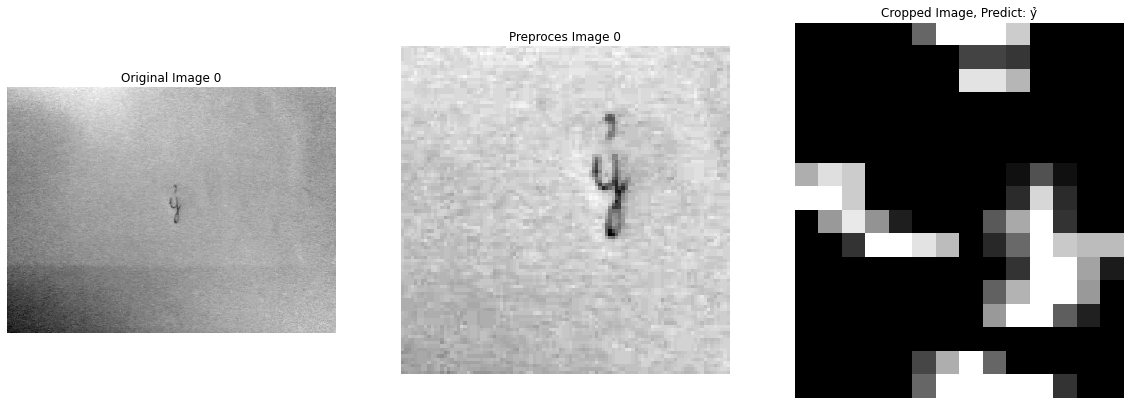

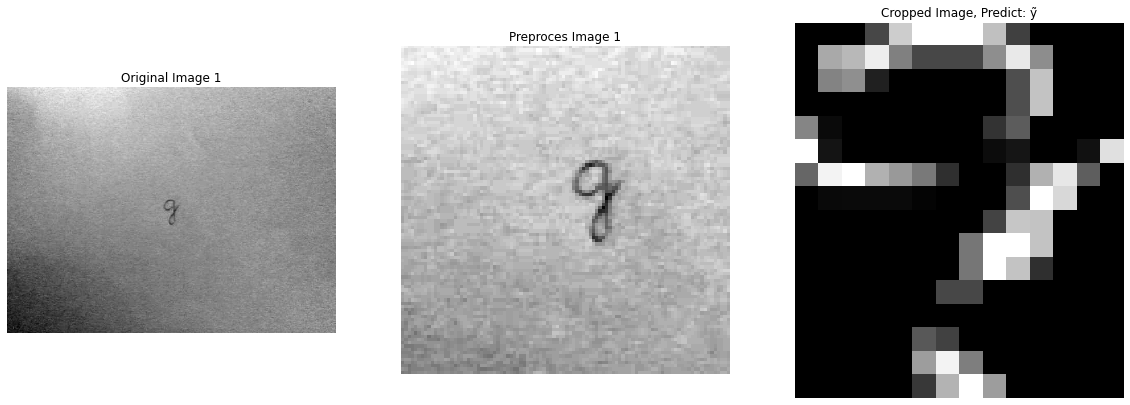

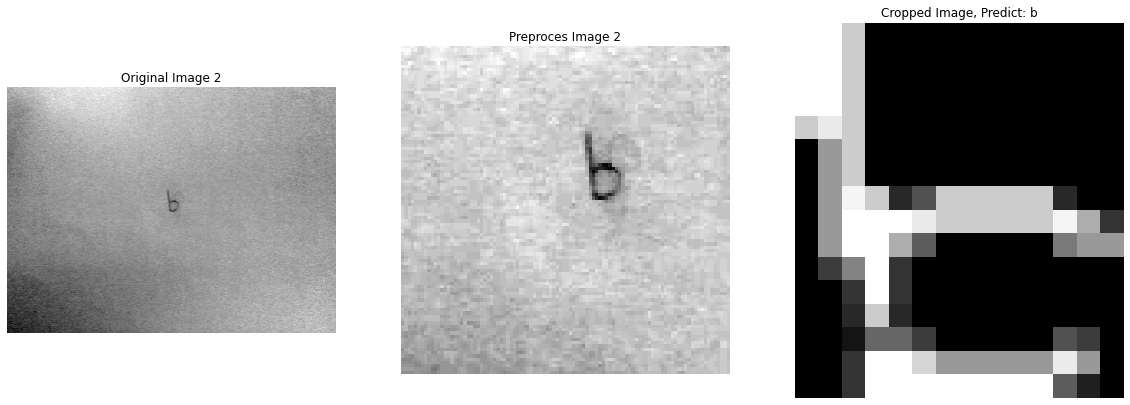

In [64]:
temp_webcam = []
for i in range(num_img_drive_old, num_img_drive_new):
  print(i)
  img_webcam_or = cv2.imread(link_to_test_img_webcam + list_img_webcam[i], 0)
  img_webcam = cv2.imread(link_to_test_img_webcam + list_img_webcam[i], cv2.IMREAD_GRAYSCALE)
  _, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
  # Show ảnh gốc
  ax = axes[0]
  ax.set_axis_off()
  ax.imshow(img_webcam_or, cmap='gray', interpolation='nearest')
  ax.set_title(f'Original Image ' + str(i - num_img_drive_old))
  # Show ảnh sau khi cắt bớt khoảng trắng
  ax = axes[1]
  ax.set_axis_off()
  img_webcam_cut = Cut_Img_webcam(img_webcam)
  ax.imshow(img_webcam_cut, cmap = 'gray', interpolation='nearest')
  ax.set_title(f'Preproces Image ' + str(i - num_img_drive_old))
  # Show ảnh sau khi chuyển sang trắng đen và predict
  ax = axes[2]
  ax.set_axis_off()
  img_webcam_crop = Crop_Images_Webcam(img_webcam_cut)
  img_webcam_re = cv2.resize(img_webcam_crop, (14,16), interpolation = cv2.INTER_AREA) # Resize ảnh về đúng kích thước của model
  predict_img_webcam = Predict_Img(img_webcam_re) # Dự doán chữ bằng phương pháp trích xuất HOG
  temp_webcam.append(predict_img_webcam)
  ax.imshow(img_webcam_re, cmap = 'gray', interpolation='nearest')
  ax.set_title(f'Cropped Image, Predict: ' + predict_img_webcam)

###Nhận xét

* Số lượng ảnh đúng: 4/5
* Ảnh chụp bằng webcam khi đưa về ảnh trắng đen bị dính nhiễu khá nhiều (webcam chưa đủ tốt). 
* Ảnh chụp phải để chữ trong phạm vi nhóm quy định mới có thể cắt được nên những ảnh mà chữ không nằm trong phạm vi quy định sẽ không thực hiện được 